In [1]:
import os
os.chdir('../')
import sys
from hydra import compose, initialize
from meg_ssl.dataclass import parse_dataset
from transformers import AutoProcessor
from meg_ssl.utils.image_preprocess import numpy2image
import os, sys
import numpy as np
import torch
import argparse
import datetime
import wandb
import torchvision.transforms as transforms
from einops import rearrange
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import copy

# own code
from meg_ssl.generate_configs.config import Config_Generative_Model
# from dataset import  create_EEG_dataset
from meg_ssl.models.dc_ldm.ldm_for_eeg import eLDM
from meg_ssl.utils.diffusion_utils.eval_metrics import get_similarity_metric

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


In [2]:
class Args():
    dataset = 'MEG'
    num_epoch = 300
    batch_size = 4
    meg_config='config_generative_model_test' 
    meg_encoder='scmbm'
    meg_preprocess='fs1000_dura200' 
    meg_exp='scmbm_4-fs1000-dura200' 
    meg_h5name='vc-fs1000-dura200-1' 
    
def update_config(args, config):
    for attr in config.__dict__:
        if hasattr(args, attr):
            if getattr(args, attr) != None:
                setattr(config, attr, getattr(args, attr))
    return config


args = Args()
config = Config_Generative_Model()
config = update_config(args, config)

if config.checkpoint_path is not None:
    model_meta = torch.load(config.checkpoint_path, map_location='cpu')
    ckp = config.checkpoint_path
    config = model_meta['config']
    config.checkpoint_path = ckp
    print('Resuming from checkpoint: {}'.format(config.checkpoint_path))

output_path = os.path.join(config.output_path, 'results', 'generation',  '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))
config.output_path = output_path
os.makedirs(output_path, exist_ok=True)


# logger = WandbLogger()
config.logger = None # logger

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(config.seed)
np.random.seed(config.seed)

crop_pix = int(config.crop_ratio*config.img_size)
def normalize(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = img * 2.0 - 1.0 # to -1 ~ 1
    return img

class random_crop:
    def __init__(self, size, p):
        self.size = size
        self.p = p
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return transforms.RandomCrop(size=(self.size, self.size))(img)
        return img
    
def to_image(img):
    if img.shape[-1] != 3:
        img = rearrange(img, 'c h w -> h w c')
    img = 255. * img
    return Image.fromarray(img.astype(np.uint8))

def channel_last(img):
        if img.shape[-1] == 3:
            return img
        return rearrange(img, 'c h w -> h w c')


img_transform_train = transforms.Compose([
    normalize,

    transforms.Resize((512, 512)),
    random_crop(config.img_size-crop_pix, p=0.5),

    transforms.Resize((512, 512)),
    channel_last
])
img_transform_test = transforms.Compose([
    normalize,

    transforms.Resize((512, 512)),
    channel_last
])

In [3]:
# TODO: read config and get dataset
with initialize(config_path='../meg_ssl/generate_configs/'):
    meg_cfg = compose(args.meg_config)
if args.meg_encoder is not None:
    with initialize(config_path='../meg_ssl/ssl_configs/model'):
        meg_cfg.meg_encoder = compose(args.meg_encoder)
    print('INFO ========= model config is overrided by ', args.meg_encoder)
if args.meg_preprocess is not None:
    with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):
        meg_cfg.preprocess = compose(args.meg_preprocess)
    print('INFO ========= preprocess config is overrided by', args.meg_preprocess)
# num_electrodes, fs, bpがh5ファイルに関係している
if args.meg_h5name is None:
    meg_cfg.h5_root = meg_cfg.h5_root.format(h5_name='fs{}-bp{}_{}'.format(meg_cfg.preprocess.brain_resample_rate, *meg_cfg.preprocess.bandpass_filter))
else:
    meg_cfg.h5_root = meg_cfg.h5_root.format(h5_name=args.meg_h5name)
    
class DiffusionDataset():
    def __init__(self, dataset, split='train'):
        self.dataset = dataset
        if split=='train':
            self.img_transform = img_transform_train
        else:
            self.img_transform = img_transform_test
        self.vit_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
        
    def __len__(self):
        return len(self.dataset)
    @property
    def datasets(self):
        return self.dataset.datasets
    
    def __getitem__(self, idx):
        ret = {}
        eeg, image = self.dataset[idx]
        image_raw = numpy2image(image)
        image_raw = self.vit_processor(images=image_raw, return_tensors="pt")
        image_raw['pixel_values'] = image_raw['pixel_values'].squeeze(0)
        ret['image_raw'] = image_raw
        ret['image'] = self.img_transform(image.astype(np.float32)/255.0)
        ret['eeg'] = torch.from_numpy(eeg)
        ret['label'] = 0 # dummy
        
        return ret

def get_dataset(cfg):
    dataset_names:dict = cfg.dataset_name
    # import pdb; pdb.set_trace()
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = False
    on_memory:bool = False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit,
                                    h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)

    return DiffusionDataset(dataset_dict['train'], 'train'), DiffusionDataset(dataset_dict['val'], 'val')

eeg_latents_dataset_train, eeg_latents_dataset_test = get_dataset(meg_cfg)
# eeg_latents_dataset_train, eeg_latents_dataset_test = create_EEG_dataset_viz( image_transform=[img_transform_train, img_transform_test])
num_voxels = int(meg_cfg.preprocess.meg_duration * meg_cfg.preprocess.brain_resample_rate) # eeg_latents_dataset_train.datasets[0].num_electrodes
meg_encoder_pretrained_path = os.path.join(meg_cfg.meg_encoder_path.format(exp_name=args.meg_exp))
meg_cfg.meg_encoder.parameters.in_chans = eeg_latents_dataset_test.datasets[0].num_electrodes
pretrain_mbm_metafile = {
    'model':torch.load(meg_encoder_pretrained_path),
    'config': meg_cfg.meg_encoder.parameters
}
# img_transform_train, img_transform_test


def train_collate_fn(batch):
    new_batch = {}
    image_raw = [numpy2image(b[1]) for b in batch]
    image_raw = vit_processor(images=image_raw, return_tensors="pt")
    image_raw['pixel_values'] = image_raw['pixel_values'].squeeze(0)
    new_batch['image_raw'] = image_raw
    new_batch['image'] = torch.stack([img_transform_train(b[1]/255.0) for b in batch])
    new_batch['eeg'] = torch.stack([torch.from_numpy(b[0]) for b in batch])
    new_batch['label'] = torch.empty(len(new_batch['image']), 1) # dummy

    return new_batch
def test_collate_fn(batch):
    new_batch = {}
    image_raw = [numpy2image(b[1]) for b in batch]
    image_raw = vit_processor(images=image_raw, return_tensors="pt")
    image_raw['pixel_values'] = image_raw['pixel_values'].squeeze(0)
    new_batch['image_raw'] = image_raw
    new_batch['image'] = torch.stack([img_transform_test(b[1]/255.0) for b in batch])
    new_batch['eeg'] = torch.stack([torch.from_numpy(b[0]) for b in batch])
    new_batch['label'] = torch.empty(len(new_batch['image']), 1) # dummy

    return new_batch

generative_model = eLDM(pretrain_mbm_metafile, num_voxels,
                device=device, pretrain_root=config.pretrain_gm_path, logger=config.logger,
                ddim_steps=config.ddim_steps, global_pool=config.global_pool, use_time_cond=config.use_time_cond, clip_tune = config.clip_tune, cls_tune = config.cls_tune)

/tmp/ipykernel_60231/3734835225.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/generate_configs/'):
/tmp/ipykernel_60231/3734835225.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/model'):


INFO ========= model config is overrided by  scmbm


/tmp/ipykernel_60231/3734835225.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):


INFO ========= preprocess config is overrided by fs1000_dura200


/home/yainoue/meg2image/codes/MEG-decoding/meg_ssl/dataclass/__init__.py:26: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../ssl_configs/dataset"):


=================GOD=================
sbj_1-train-session_1
dataset_info_list:  [{'image_root': '/storage/dataset/ECoG/internal/GODv2-4/images_trn', 'meg_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001', 'meg_label_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/labels/ses_1', 'meg_trigger_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/trigger/ses01', 'meg_rest_path': '/work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001', 'sbj_name': 'sbj01', 'h5_file_name': '../../../dataset/ssl_dataset/vc-fs1000-dura200-1/GOD/sbj01_data_block001.h5', 'image_id_path': '/work/project/MEG_GOD/GOD_dataset/clip_image_training.mat'}]
ROI:  ['occipital/left', 'occipital/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
num channels:  22
load h5 file ../../../dataset/ssl_dataset/vc-fs1000-dura200-1/GOD/sbj01_data_block001.h5
=================GOD=================
sb

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 860.51 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/yainoue/meg2image/codes/MEG-decoding/meg_ssl/models/sc_mbm/utils.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


missing keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'decoder_blocks.2.norm1.bias', 'decoder_blocks.2.attn.qkv.weight', 'decod

In [4]:
grid, _ = generative_model.generate(eeg_latents_dataset_train, 1,
                config.ddim_steps, config.HW, 5) # generate 10 instances
grid_imgs = Image.fromarray(grid.astype(np.uint8))
grid_imgs.save(os.path.join('./tmps/','samples_train.png'))

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'image_raw': {'pixel_values': tensor([[[-0.0259,  0.1931,  0.0763,  ...,  0.4267,  0.0179,  0.2515],
         [-0.0550,  0.1639,  0.1201,  ...,  0.4267,  0.2223,  0.2807],
         [-0.1134,  0.1201,  0.1785,  ...,  0.1493,  0.4997,  0.1493],
         ...,
         [ 0.9814,  0.6749,  0.8647,  ..., -1.4857, -1.4857, -1.4419],
         [ 0.8063,  0.8355,  1.0690,  ..., -1.3981, -1.4419, -1.5003],
         [ 1.0252,  0.9814,  1.2588,  ..., -1.3543, -1.4273, -1.5295]],

        [[-0.1012,  0.1239,  0.0038,  ...,  0.3340, -0.1313,  0.1089],
         [-0.1313,  0.0939,  0.0488,  ...,  0.2589, -0.0112,  0.0338],
         [-0.1913,  0.0488,  0.1089,  ..., -0.0862,  0.2289, -0.1463],
         ...,
         [ 1.6697,  1.3845,  1.5946,  ..., -1.4820, -1.5120, -1.4820],
         [ 1.5196,  1.4896,  1.6697,  ..., -1.4369, -1.4519, -1.4970],
         [ 1.6997,  1.5796,  1.7747,  ..., -1.4219, -1.4369, -1.4970]],

        [[-0.3426, -0.1293, -0.2431,  ...,  0.0271, -0.4137, -0.1862],
         [-0.3

PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.52it/s]


{'image_raw': {'pixel_values': tensor([[[-1.3689, -1.3981, -1.3981,  ..., -1.6755, -1.6901, -1.6901],
         [-1.3689, -1.3981, -1.3981,  ..., -1.6755, -1.6755, -1.6755],
         [-1.3689, -1.3981, -1.3981,  ..., -1.6755, -1.6609, -1.6609],
         ...,
         [-1.1937, -1.2521, -1.3543,  ..., -1.5295, -1.5149, -1.5149],
         [-1.1937, -1.2375, -1.3543,  ..., -1.5149, -1.5149, -1.5149],
         [-1.1937, -1.2375, -1.3397,  ..., -1.5295, -1.5295, -1.5295]],

        [[-1.2268, -1.2568, -1.2568,  ..., -1.3769, -1.3919, -1.3919],
         [-1.2268, -1.2568, -1.2568,  ..., -1.3769, -1.3769, -1.3769],
         [-1.2268, -1.2568, -1.2568,  ..., -1.3769, -1.3619, -1.3619],
         ...,
         [-0.7166, -0.7316, -0.7316,  ..., -0.8967, -0.9267, -0.9267],
         [-0.7466, -0.7466, -0.7616,  ..., -0.8967, -0.9267, -0.9267],
         [-0.7466, -0.7466, -0.7616,  ..., -0.9117, -0.9417, -0.9567]],

        [[-1.0536, -1.0821, -1.0821,  ..., -1.1816, -1.1958, -1.1958],
         [-1.0

PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.70it/s]


{'image_raw': {'pixel_values': tensor([[[ 0.5581,  0.5143,  0.4413,  ...,  0.0471, -0.0113, -0.0259],
         [ 0.7333,  0.7333,  0.6019,  ..., -0.0696, -0.1280, -0.1280],
         [ 0.9084,  0.7917,  0.6019,  ...,  0.0179, -0.1280, -0.1426],
         ...,
         [ 0.4413,  0.3099, -0.0113,  ..., -0.0113,  0.1201,  0.0179],
         [ 0.3391,  0.0909,  0.1493,  ...,  0.3245, -0.4200, -0.1718],
         [ 0.2515,  0.1347,  0.1785,  ...,  0.2953,  0.1201,  0.3829]],

        [[ 1.2044,  1.1594,  1.0844,  ...,  0.7392,  0.7542,  0.7692],
         [ 1.3845,  1.3845,  1.2495,  ...,  0.6191,  0.6491,  0.6792],
         [ 1.5646,  1.4446,  1.2495,  ...,  0.7092,  0.6491,  0.6642],
         ...,
         [ 1.1894,  1.0544,  0.7092,  ...,  0.5891,  0.8593,  0.7992],
         [ 1.0544,  0.7992,  0.8893,  ...,  1.0243,  0.2589,  0.4841],
         [ 0.9493,  0.8442,  0.9193,  ...,  1.0393,  0.7542,  0.9943]],

        [[ 1.6624,  1.6198,  1.5487,  ...,  1.2358,  1.2358,  1.2500],
         [ 1.8

PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.58it/s]


{'image_raw': {'pixel_values': tensor([[[-0.0113, -0.0405, -0.0259,  ..., -0.2448, -0.2010, -0.1864],
         [ 0.0179, -0.0113,  0.0033,  ..., -0.1426, -0.1280, -0.1280],
         [ 0.0471,  0.0325,  0.0325,  ..., -0.0696, -0.0842, -0.0842],
         ...,
         [ 1.4778,  0.6749,  0.6165,  ..., -0.5076, -0.9456, -0.6390],
         [-0.1426, -0.6974, -0.3178,  ..., -0.9602, -1.3251, -0.9748],
         [-0.2740, -0.2302, -0.0988,  ..., -0.3762, -0.3908, -0.5806]],

        [[ 0.3190,  0.2890,  0.3040,  ...,  0.3490,  0.4090,  0.4240],
         [ 0.3490,  0.3340,  0.3340,  ...,  0.4540,  0.4691,  0.4691],
         [ 0.3790,  0.3640,  0.3640,  ...,  0.5141,  0.4991,  0.4991],
         ...,
         [ 1.6547,  0.8142,  0.7692,  ..., -0.2513, -0.3114,  0.2139],
         [-0.2213, -0.8216, -0.4464,  ..., -0.2963, -0.4314,  0.0789],
         [-0.4314, -0.4164, -0.3264,  ...,  0.4540,  0.5891,  0.5141]],

        [[ 0.6528,  0.6386,  0.6386,  ...,  0.7239,  0.7523,  0.7666],
         [ 0.6

PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.47it/s]


{'image_raw': {'pixel_values': tensor([[[1.2734, 1.2734, 1.2734,  ..., 0.8647, 0.9376, 1.0836],
         [1.2880, 1.2880, 1.2880,  ..., 0.6311, 0.5873, 0.7041],
         [1.3026, 1.3026, 1.3026,  ..., 0.4559, 0.4851, 0.5873],
         ...,
         [0.6895, 0.7917, 1.5216,  ..., 1.0544, 1.0398, 1.3318],
         [0.9814, 0.7917, 1.0398,  ..., 1.1858, 1.0690, 1.2004],
         [1.2296, 1.0982, 1.0106,  ..., 1.2296, 1.3464, 1.1420]],

        [[0.4841, 0.4841, 0.4841,  ..., 0.3940, 0.3790, 0.4691],
         [0.4991, 0.4991, 0.4991,  ..., 0.3190, 0.3490, 0.4240],
         [0.5141, 0.5141, 0.5141,  ..., 0.2289, 0.2289, 0.2890],
         ...,
         [0.9493, 1.0243, 1.7297,  ..., 1.4295, 1.3995, 1.6997],
         [1.2194, 0.9793, 1.1894,  ..., 1.5346, 1.3995, 1.5346],
         [1.4446, 1.2795, 1.1444,  ..., 1.5796, 1.6697, 1.4596]],

        [[0.2688, 0.2688, 0.2688,  ..., 0.2688, 0.2262, 0.2973],
         [0.2831, 0.2831, 0.2831,  ..., 0.1835, 0.1835, 0.2404],
         [0.2973, 0.2973, 0

PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.81it/s]


In [5]:
grid_imgs.save(os.path.join('./tmps/','samples_train.png'))

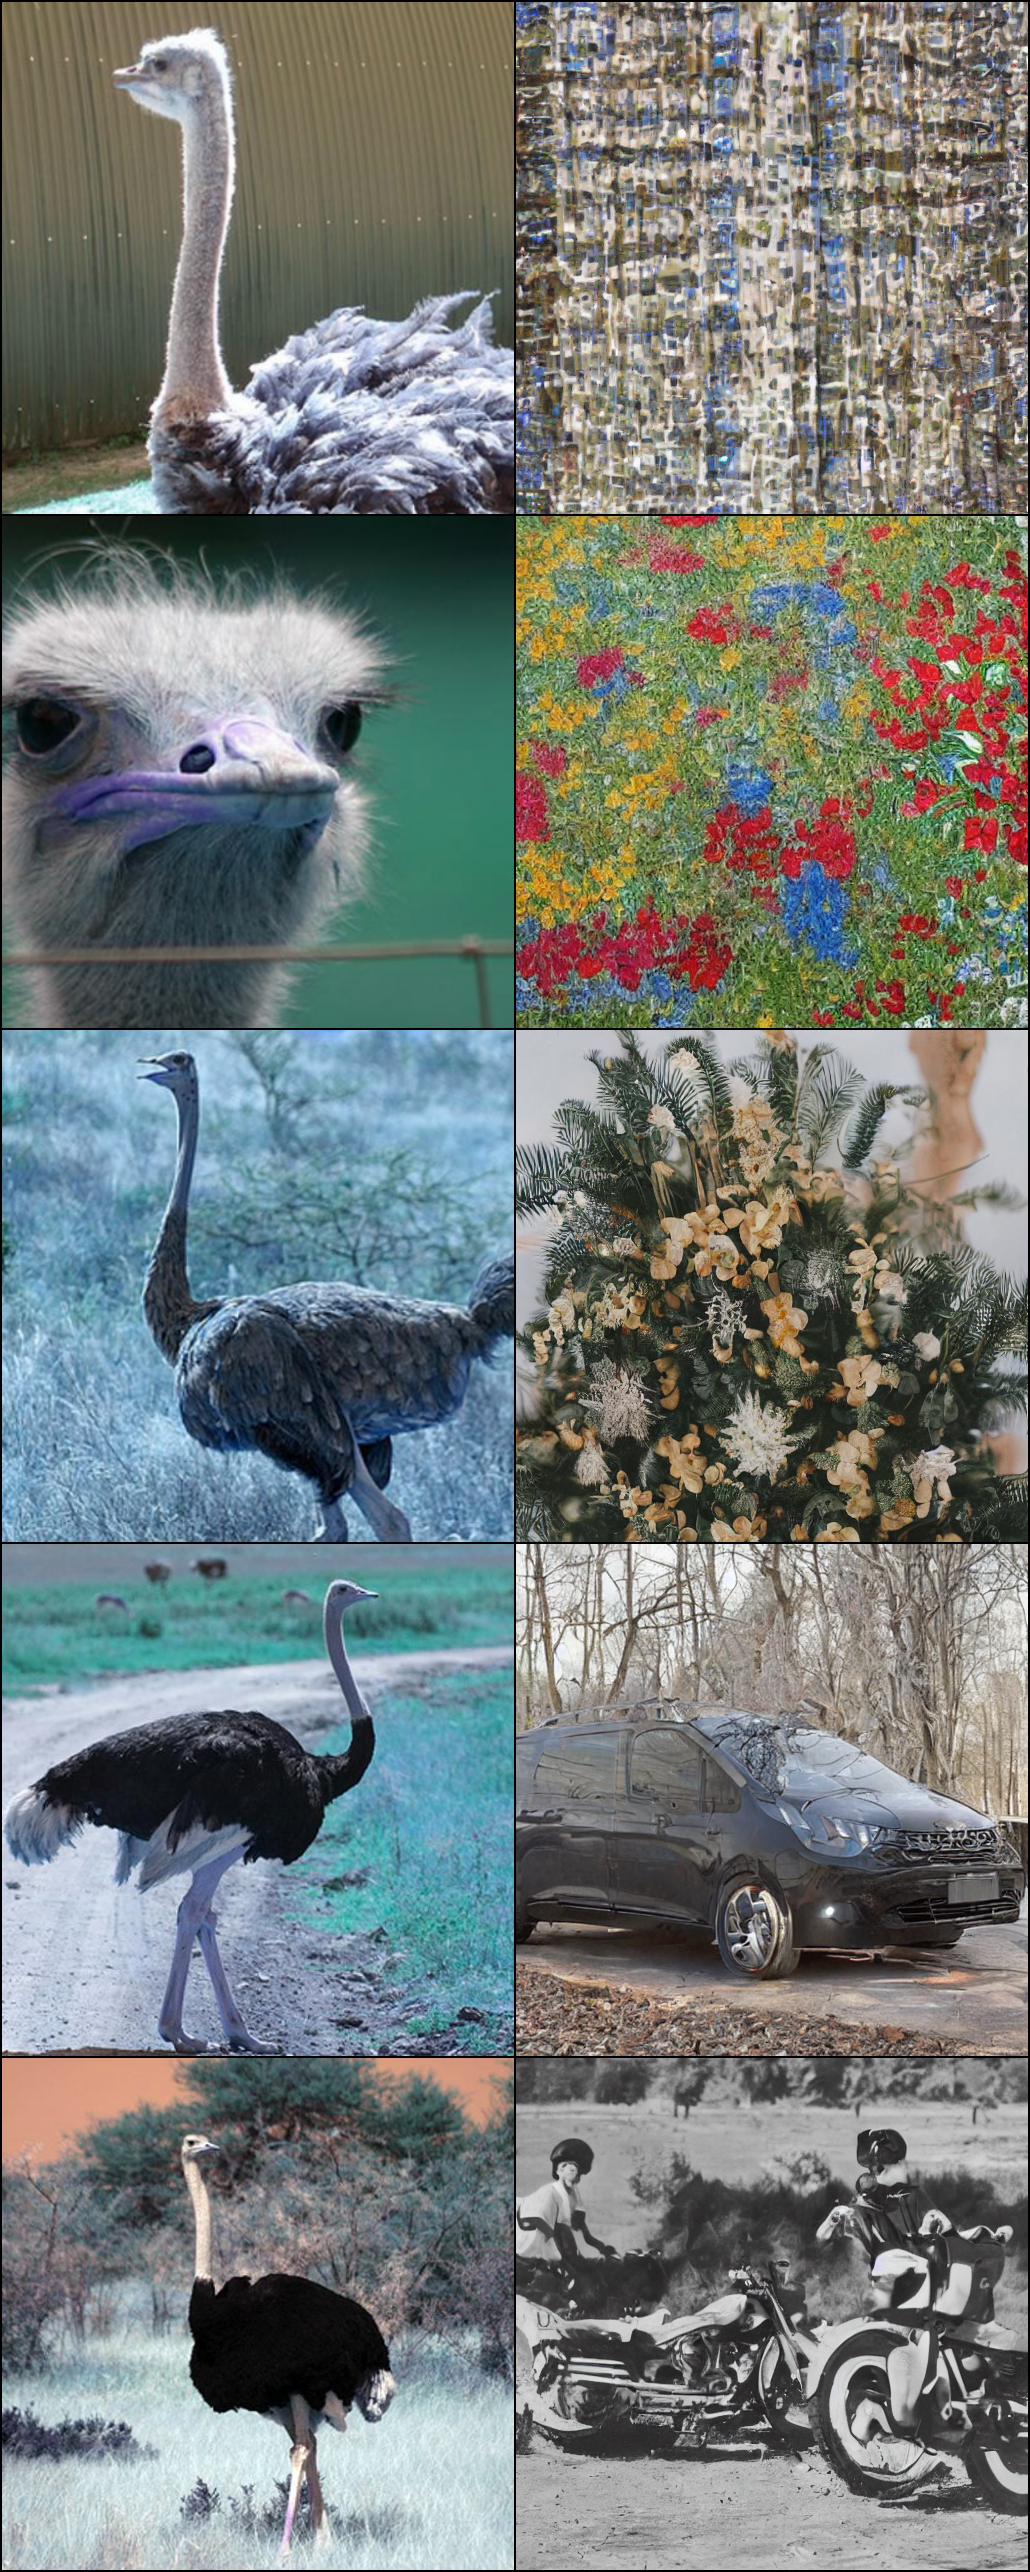

In [6]:
grid_imgs

In [7]:
def create_trainer(num_epoch, precision=32, accumulate_grad_batches=2,logger=None,check_val_every_n_epoch=0):
    acc = 'gpu' if torch.cuda.is_available() else 'cpu'
    return pl.Trainer(accelerator=acc, max_epochs=num_epoch, logger=logger,
            precision=precision, accumulate_grad_batches=accumulate_grad_batches,
            enable_checkpointing=False, enable_model_summary=False, gradient_clip_val=0.5,
            check_val_every_n_epoch=check_val_every_n_epoch)

trainer = create_trainer(config.num_epoch, config.precision, config.accumulate_grad, config.logger, check_val_every_n_epoch=2)
generative_model.finetune(trainer, eeg_latents_dataset_train, eeg_latents_dataset_test,
            config.batch_size, config.lr, config.output_path, config=config, collate_fn=None)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



##### Stage One: only optimize conditional encoders #####


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/yainoue/.local/lib/python3.8/site-packages/torch/optim/adamw.py:50: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


LatentDiffusion: Only optimizing conditioner params!
Sanity Checking: 0it [00:00, ?it/s]

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Sanity Checking DataLoader 0:   0%|                                                               | 0/2 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps



PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.48it/s]


PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.43it/s]


PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.50it/s]


PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.43it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps



PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.40it/s]


PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]


PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:16,  3.28it/s]


PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.39it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps



PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.41it/s]


PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.32it/s]


PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.38it/s]


PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.38it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps



PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.40it/s]


PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:33,  3.55it/s]


PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.44it/s]


PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.42it/s]


/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 0:   0%|                                                                                  | 0/150 [00:00<?, ?it/s]

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 1:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.156, train/loss_vlb=0.00185, train/loss=0.473, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 1: 100%|█| 150/150 [05:20<00:00,  2.14s/it, v_num=19, train/loss_simple=0.156, train/loss_vlb=0.00185, train/loss=
Validation: 0it [00:00, ?it/s]

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:26,  1.70it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:45,  2.34it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:29,  2.75it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:23,  2.94it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.16it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.27it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:13,  3.32it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:55,  3.38it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:56,  3.30it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:56,  3.28it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:55,  3.32it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:54,  3.35it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:54,  3.34it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:53,  3.39it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:52,  3.44it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:34,  3.51it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.45it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.43it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:39<00:34,  3.39it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.39it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.41it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.47it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.23it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:57<00:17,  3.28it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.34it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:58<00:16,  3.37it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.33it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.32it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:59<00:15,  3.37it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:28,  1.68it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:45,  2.35it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:28,  2.79it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:18,  3.14it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:13,  3.31it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:12,  3.35it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:12,  3.35it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:53,  3.47it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.46it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.47it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:53,  3.40it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:53,  3.39it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:53,  3.38it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.46it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:52,  3.43it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.44it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:34,  3.47it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.46it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.45it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:34,  3.44it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.44it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.44it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.45it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.40it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.41it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.47it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.40it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.34it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:16,  3.24it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.29it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:25,  1.71it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:44,  2.37it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:30,  2.72it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:24,  2.93it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:19,  3.08it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.17it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:13,  3.29it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:53,  3.47it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:52,  3.55it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:51,  3.58it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:50,  3.60it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:50,  3.59it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.51it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:50,  3.58it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:50,  3.53it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.41it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.41it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.41it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:39<00:34,  3.47it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.52it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.53it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:32,  3.55it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.37it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.38it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.35it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.35it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.36it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.44it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.38it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.40it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:37,  1.58it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:49,  2.27it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:35,  2.58it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:25,  2.87it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:20,  3.05it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.20it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:14,  3.25it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:51,  3.65it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:50,  3.65it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:50,  3.63it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:50,  3.62it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:50,  3.61it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.51it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:51,  3.52it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:51,  3.47it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.39it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:36,  3.35it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.40it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.46it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.48it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.51it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.53it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.48it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.59it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.55it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.49it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.33it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.35it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:57<00:15,  3.37it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [06:44<08:34,  6.12s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [06:51<00:56,  3.12s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [06:53<00:02,  2.78s/it]
Epoch 1: 100%|█| 150/150 [12:16<00:00,  4.91s/it, v_num=19, train/loss_simple=0.156, train/loss_vlb=0.00185, train/loss=
Epoch 2:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.168, train/loss_vlb=0.00299, train/loss=0.433, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 3:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.145, train/loss_vlb=0.00104, train/loss=0.396, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 3: 100%|█| 150/150 [05:21<00:00,  2.14s/it, v_num=19, train/loss_simple=0.145, train/loss_vlb=0.00104, train/loss=

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:16,  1.82it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:37,  2.55it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:25,  2.89it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:20,  3.07it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.17it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.18it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:15,  3.21it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:54,  3.41it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.42it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.46it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.48it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.50it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:50,  3.55it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:50,  3.55it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:34,  3.54it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:34,  3.53it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:37<00:33,  3.53it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.49it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.51it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:38<00:33,  3.48it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.47it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.43it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.34it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.42it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:56<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:57<00:15,  3.43it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:25,  1.71it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:42,  2.41it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:26,  2.85it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:19,  3.08it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.17it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:15,  3.23it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:14,  3.27it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:55,  3.33it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:55,  3.32it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:54,  3.35it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:53,  3.38it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:53,  3.35it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:54,  3.33it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:53,  3.35it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.48it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:34,  3.52it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.48it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:33,  3.53it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.49it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:32,  3.56it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.57it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:32,  3.51it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.38it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.42it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:15,  3.51it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:15,  3.48it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.44it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:14,  3.51it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.49it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:26,  1.70it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:43,  2.40it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:29,  2.75it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:22,  2.99it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:18,  3.14it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.21it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:14,  3.28it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.41it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.48it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.51it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:20<00:52,  3.52it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.48it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.54it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:51,  3.53it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:51,  3.47it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.40it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:35,  3.44it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.50it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:33,  3.54it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.47it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.50it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.52it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:32,  3.56it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.32it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.40it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.40it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.40it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.42it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.39it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:57<00:15,  3.34it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.36it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:25,  1.71it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:44,  2.38it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:29,  2.76it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:21,  3.02it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.20it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.29it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:12,  3.35it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:54,  3.42it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:54,  3.40it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:53,  3.45it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.47it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.50it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.46it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:51,  3.47it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.42it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:35,  3.41it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.44it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:33,  3.51it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.52it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.48it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.53it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:32,  3.51it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.44it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.40it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.42it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.43it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.46it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.44it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [06:36<08:24,  6.01s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [06:44<00:55,  3.06s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [06:46<00:02,  2.73s/it]
Epoch 3: 100%|█| 150/150 [12:10<00:00,  4.87s/it, v_num=19, train/loss_simple=0.145, train/loss_vlb=0.00104, train/loss=
Epoch 4:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.158, train/loss_vlb=0.00248, train/loss=0.396, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 5:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.150, train/loss_vlb=0.00253, train/loss=0.377, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 5: 100%|█| 150/150 [05:20<00:00,  2.13s/it, v_num=19, train/loss_simple=0.150, train/loss_vlb=0.00253, train/loss=

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:26,  1.70it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:42,  2.43it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:27,  2.82it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:20,  3.05it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.21it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:13,  3.34it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:10,  3.43it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:54,  3.43it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:52,  3.51it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:51,  3.54it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.50it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.46it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.47it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:52,  3.40it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.44it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.43it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.50it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.48it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.53it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:32,  3.56it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:32,  3.58it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:32,  3.50it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.41it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.44it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.41it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.41it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.41it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.44it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.44it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:31,  1.64it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:47,  2.31it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:31,  2.71it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:22,  3.00it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.19it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.26it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:11,  3.38it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:54,  3.42it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.42it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.41it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:55,  3.27it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:56,  3.21it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:55,  3.26it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:53,  3.39it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:52,  3.38it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:34,  3.54it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:34,  3.51it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.47it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.41it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:34,  3.45it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.45it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.45it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.47it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.40it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.41it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.35it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.36it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.35it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:25,  1.71it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:41,  2.44it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:29,  2.75it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:22,  2.97it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.16it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.27it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:12,  3.33it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.41it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.46it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.50it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.50it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.44it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:54,  3.32it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:53,  3.34it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:53,  3.32it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.47it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.45it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.42it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:39<00:34,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.39it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.42it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.45it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.36it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.37it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.35it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.50it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:14,  3.52it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.55it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:18,  1.80it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:38,  2.53it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:24,  2.92it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:21,  3.02it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.18it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:01<01:13,  3.32it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:10,  3.43it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:55,  3.38it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:53,  3.39it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:51,  3.51it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:51,  3.46it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.45it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.45it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.50it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.47it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:34,  3.44it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.40it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.48it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.47it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.49it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.45it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.45it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.38it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.32it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.28it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [06:35<08:23,  5.99s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [06:42<00:54,  3.05s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [06:45<00:02,  2.72s/it]
Epoch 5: 100%|█| 150/150 [12:07<00:00,  4.85s/it, v_num=19, train/loss_simple=0.150, train/loss_vlb=0.00253, train/loss=
Epoch 6:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.153, train/loss_vlb=0.00251, train/loss=0.369, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 7:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.160, train/loss_vlb=0.00217, train/loss=0.365, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 7: 100%|█| 150/150 [05:18<00:00,  2.12s/it, v_num=19, train/loss_simple=0.160, train/loss_vlb=0.00217, train/loss=

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:27,  1.69it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:42,  2.41it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:28,  2.78it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:20,  3.05it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.21it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:12,  3.35it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:10,  3.46it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.39it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.40it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.46it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.47it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:53,  3.38it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.44it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:51,  3.48it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:51,  3.46it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:36,  3.36it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:36,  3.33it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.36it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.36it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:35,  3.36it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.41it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.35it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:34,  3.37it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.32it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:17,  3.33it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.30it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.28it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.33it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:25,  1.71it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:42,  2.41it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:28,  2.78it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:21,  3.01it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.15it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.27it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:13,  3.31it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.42it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.44it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.47it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:20<00:52,  3.50it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:51,  3.50it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:21<00:52,  3.46it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:52,  3.43it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:38<00:36,  3.33it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.37it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.37it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:39<00:35,  3.37it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.38it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.34it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:40<00:34,  3.32it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.49it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:57<00:16,  3.46it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.41it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.36it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:58<00:16,  3.29it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:16,  3.30it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.27it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:59<00:15,  3.27it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:24,  1.72it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:41,  2.44it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:27,  2.83it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:21,  3.02it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.19it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:13,  3.32it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:10,  3.44it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.39it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.43it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.48it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.46it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.44it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:51,  3.49it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:50,  3.55it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:50,  3.52it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:36,  3.32it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.39it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.35it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.33it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:35,  3.34it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.37it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.38it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.40it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.43it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.46it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.44it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:15,  3.45it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:15,  3.51it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:14,  3.56it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:14,  3.54it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.54it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:18,  1.80it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:38,  2.52it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:26,  2.87it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:20,  3.07it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:16,  3.22it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:01<01:12,  3.35it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:10,  3.43it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:53,  3.45it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:18<00:53,  3.47it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.45it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:53,  3.43it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:19<00:52,  3.45it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.47it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:51,  3.45it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.39it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:36,  3.35it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.37it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:35,  3.33it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:35,  3.29it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.38it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:34,  3.35it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.27it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:17,  3.21it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:17,  3.21it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.29it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.31it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:16,  3.31it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.32it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.41it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [06:35<08:23,  6.00s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [06:45<00:55,  3.07s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [06:47<00:02,  2.73s/it]
Epoch 7: 100%|█| 150/150 [12:08<00:00,  4.86s/it, v_num=19, train/loss_simple=0.160, train/loss_vlb=0.00217, train/loss=
Epoch 8:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.163, train/loss_vlb=0.00258, train/loss=0.356, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 9:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.157, train/loss_vlb=0.00188, train/loss=0.338, tra

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 9: 100%|█| 150/150 [05:19<00:00,  2.13s/it, v_num=19, train/loss_simple=0.157, train/loss_vlb=0.00188, train/loss=

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]###### run full validation! ######

rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<03:58,  1.05it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:01<02:45,  1.50it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<02:22,  1.73it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:02<02:10,  1.88it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:02<02:05,  1.95it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:03<02:01,  2.01it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:03<01:56,  2.09it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:30<01:27,  2.13it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:31<01:26,  2.15it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:31<01:26,  2.12it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:32<01:26,  2.12it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:32<01:26,  2.11it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:33<01:25,  2.11it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:33<01:25,  2.11it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:34<01:24,  2.11it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [01:01<00:57,  2.10it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [01:01<00:57,  2.09it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [01:02<00:56,  2.12it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [01:02<00:55,  2.15it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [01:03<00:54,  2.15it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [01:03<00:54,  2.14it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [01:04<00:55,  2.09it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [01:04<00:55,  2.08it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [01:31<00:28,  2.06it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [01:32<00:27,  2.08it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [01:32<00:26,  2.13it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [01:33<00:25,  2.16it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [01:33<00:25,  2.15it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [01:34<00:24,  2.15it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [01:34<00:24,  2.12it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [01:34<00:24,  2.11it/s]

PLMS Sampler:  80%|█████

rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<03:41,  1.13it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:01<02:42,  1.52it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<02:18,  1.78it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:02<02:12,  1.86it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:02<02:06,  1.93it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:03<02:00,  2.02it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:03<01:57,  2.06it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:30<01:27,  2.12it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:31<01:27,  2.12it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:31<01:28,  2.09it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:32<01:26,  2.12it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:32<01:26,  2.11it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:33<01:25,  2.11it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:33<01:24,  2.13it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:34<01:25,  2.10it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [01:01<00:58,  2.08it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [01:01<00:57,  2.11it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [01:02<00:56,  2.11it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [01:02<00:56,  2.12it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [01:03<00:56,  2.09it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [01:03<00:56,  2.09it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [01:04<00:55,  2.07it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [01:04<00:53,  2.15it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [01:31<00:27,  2.10it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [01:31<00:26,  2.12it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [01:32<00:26,  2.11it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [01:32<00:26,  2.08it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [01:33<00:25,  2.08it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [01:33<00:25,  2.09it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [01:34<00:24,  2.10it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [01:34<00:24,  2.10it/s]

PLMS Sampler:  80%|█████

rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<04:01,  1.03it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:01<02:49,  1.46it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<02:23,  1.72it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:02<02:10,  1.88it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:02<02:03,  1.98it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:03<02:01,  2.00it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:03<01:59,  2.03it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:30<01:29,  2.08it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:31<01:29,  2.06it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:31<01:29,  2.05it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:32<01:28,  2.07it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:32<01:26,  2.11it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:33<01:26,  2.10it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:33<01:26,  2.09it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:34<01:24,  2.12it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [01:01<00:57,  2.13it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [01:01<00:57,  2.12it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [01:02<00:56,  2.11it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [01:02<00:56,  2.10it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [01:03<00:56,  2.10it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [01:03<00:56,  2.08it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [01:04<00:56,  2.06it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [01:04<00:56,  2.05it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [01:31<00:26,  2.15it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [01:32<00:26,  2.16it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [01:32<00:26,  2.13it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [01:33<00:25,  2.13it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [01:33<00:25,  2.11it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [01:34<00:25,  2.10it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [01:34<00:25,  2.07it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [01:35<00:24,  2.09it/s]

PLMS Sampler:  80%|█████

rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<03:58,  1.05it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:01<02:45,  1.50it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<02:23,  1.72it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:02<02:13,  1.84it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:02<02:07,  1.91it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:03<02:03,  1.97it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:03<02:01,  2.01it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:30<01:27,  2.12it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:31<01:26,  2.13it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:31<01:26,  2.12it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:32<01:27,  2.10it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:32<01:26,  2.09it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:33<01:25,  2.11it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:33<01:26,  2.09it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:34<01:25,  2.09it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [01:01<00:57,  2.14it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [01:01<00:57,  2.11it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [01:02<00:57,  2.10it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [01:02<00:56,  2.12it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [01:03<00:56,  2.08it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [01:03<00:56,  2.07it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [01:04<00:55,  2.07it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [01:04<00:55,  2.06it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [01:31<00:27,  2.08it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [01:32<00:27,  2.06it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [01:32<00:27,  2.07it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [01:33<00:25,  2.12it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [01:33<00:25,  2.09it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [01:34<00:25,  2.11it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [01:34<00:24,  2.12it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [01:35<00:24,  2.12it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [11:10<14:13, 10.16s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [11:19<01:32,  5.15s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [11:21<00:04,  4.58s/it]
Epoch 9: 100%|█| 150/150 [16:44<00:00,  6.69s/it, v_num=19, train/loss_simple=0.157, train/loss_vlb=0.00188, train/loss=
Epoch 10:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.150, train/loss_vlb=0.00222, train/loss=0.318, tr

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 11:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.164, train/loss_vlb=0.00282, train/loss=0.318, tr

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 11: 100%|█| 150/150 [05:19<00:00,  2.13s/it, v_num=19, train/loss_simple=0.164, train/loss_vlb=0.00282, train/loss

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/150 [00:00<?, ?it/s]rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:15,  1.83it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:36,  2.56it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:25,  2.88it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:20,  3.07it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:18,  3.11it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.19it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:16,  3.17it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:18<00:55,  3.38it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:54,  3.37it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.43it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:52,  3.50it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:53,  3.41it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:20<00:52,  3.43it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:36,  3.32it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:35,  3.40it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.47it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:33,  3.50it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:33,  3.49it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:33,  3.45it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.43it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:34,  3.37it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.38it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.45it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:56<00:16,  3.38it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.38it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:57<00:15,  3.38it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.35it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:23,  1.73it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:41,  2.44it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:30,  2.74it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:23,  2.96it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:17,  3.17it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:14,  3.29it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:12,  3.37it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.40it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.44it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:53,  3.41it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:53,  3.42it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:54,  3.37it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:54,  3.34it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:53,  3.36it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:53,  3.33it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.39it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:37<00:35,  3.38it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.37it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.42it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:34,  3.42it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.42it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:33,  3.43it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:34,  3.33it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.45it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:16,  3.49it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.43it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.39it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.37it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.33it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.35it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.29it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:22,  1.75it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:43,  2.39it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:29,  2.77it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:22,  2.98it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:18,  3.12it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:16,  3.18it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:18,  3.10it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:54,  3.41it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.44it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:52,  3.51it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:19<00:51,  3.53it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:52,  3.45it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:52,  3.44it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:52,  3.40it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:52,  3.43it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:37<00:35,  3.46it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.43it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:34,  3.49it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:34,  3.44it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:38<00:34,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.38it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.41it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:39<00:33,  3.44it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:17,  3.38it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:56<00:17,  3.32it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.35it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:16,  3.40it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:57<00:16,  3.35it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.32it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.37it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:15,  3.34it/s]

PLMS Sampler:  80%|█████

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 4, 64, 64)
Running PLMS Sampling with 250 timesteps




PLMS Sampler:   0%|                                                                             | 0/250 [00:00<?, ?it/s]

PLMS Sampler:   0%|▎                                                                    | 1/250 [00:00<02:20,  1.77it/s]

PLMS Sampler:   1%|▌                                                                    | 2/250 [00:00<01:40,  2.47it/s]

PLMS Sampler:   1%|▊                                                                    | 3/250 [00:01<01:27,  2.82it/s]

PLMS Sampler:   2%|█                                                                    | 4/250 [00:01<01:22,  3.00it/s]

PLMS Sampler:   2%|█▍                                                                   | 5/250 [00:01<01:20,  3.05it/s]

PLMS Sampler:   2%|█▋                                                                   | 6/250 [00:02<01:17,  3.15it/s]

PLMS Sampler:   3%|█▉                                                                   | 7/250 [00:02<01:15,  3.23it/s]

PLMS Sampler:   3%|██▏

PLMS Sampler:  26%|█████████████████▍                                                  | 64/250 [00:19<00:53,  3.49it/s]

PLMS Sampler:  26%|█████████████████▋                                                  | 65/250 [00:19<00:53,  3.43it/s]

PLMS Sampler:  26%|█████████████████▉                                                  | 66/250 [00:19<00:54,  3.36it/s]

PLMS Sampler:  27%|██████████████████▏                                                 | 67/250 [00:20<00:54,  3.36it/s]

PLMS Sampler:  27%|██████████████████▍                                                 | 68/250 [00:20<00:53,  3.39it/s]

PLMS Sampler:  28%|██████████████████▊                                                 | 69/250 [00:20<00:53,  3.37it/s]

PLMS Sampler:  28%|███████████████████                                                 | 70/250 [00:20<00:53,  3.35it/s]

PLMS Sampler:  28%|███████████████████▎                                                | 71/250 [00:21<00:52,  3.39it/s]

PLMS Sampler:  29%|█████

PLMS Sampler:  51%|██████████████████████████████████▎                                | 128/250 [00:38<00:36,  3.37it/s]

PLMS Sampler:  52%|██████████████████████████████████▌                                | 129/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  52%|██████████████████████████████████▊                                | 130/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  52%|███████████████████████████████████                                | 131/250 [00:38<00:35,  3.38it/s]

PLMS Sampler:  53%|███████████████████████████████████▍                               | 132/250 [00:39<00:34,  3.39it/s]

PLMS Sampler:  53%|███████████████████████████████████▋                               | 133/250 [00:39<00:34,  3.35it/s]

PLMS Sampler:  54%|███████████████████████████████████▉                               | 134/250 [00:39<00:34,  3.37it/s]

PLMS Sampler:  54%|████████████████████████████████████▏                              | 135/250 [00:40<00:33,  3.40it/s]

PLMS Sampler:  54%|█████

PLMS Sampler:  77%|███████████████████████████████████████████████████▍               | 192/250 [00:56<00:16,  3.53it/s]

PLMS Sampler:  77%|███████████████████████████████████████████████████▋               | 193/250 [00:57<00:16,  3.48it/s]

PLMS Sampler:  78%|███████████████████████████████████████████████████▉               | 194/250 [00:57<00:16,  3.45it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▎              | 195/250 [00:57<00:15,  3.47it/s]

PLMS Sampler:  78%|████████████████████████████████████████████████████▌              | 196/250 [00:58<00:15,  3.39it/s]

PLMS Sampler:  79%|████████████████████████████████████████████████████▊              | 197/250 [00:58<00:15,  3.39it/s]

PLMS Sampler:  79%|█████████████████████████████████████████████████████              | 198/250 [00:58<00:15,  3.42it/s]

PLMS Sampler:  80%|█████████████████████████████████████████████████████▎             | 199/250 [00:58<00:14,  3.43it/s]

PLMS Sampler:  80%|█████


Validation DataLoader 0:  44%|█████████████████████████                                | 66/150 [06:34<08:21,  5.97s/it]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████▎      | 132/150 [06:43<00:55,  3.06s/it]


Validation DataLoader 0:  99%|███████████████████████████████████████████████████████▋| 149/150 [06:45<00:02,  2.72s/it]
Epoch 11: 100%|█| 150/150 [12:08<00:00,  4.85s/it, v_num=19, train/loss_simple=0.164, train/loss_vlb=0.00282, train/loss
Epoch 12:   0%| | 0/150 [00:00<?, ?it/s, v_num=19, train/loss_simple=0.175, train/loss_vlb=0.00463, train/loss=0.315, tr

/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yainoue/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Epoch 12:   3%| | 5/150 [00:12<05:54,  2.45s/it, v_num=19, train/loss_simple=0.175, train/loss_vlb=0.00463, train/loss=0

/home/yainoue/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


KeyboardInterrupt: 